In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
from tqdm import tqdm
import time

import glob
import imageio

from IPython import display

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
X = np.load('/content/drive/MyDrive/words_x.npy')
Y = np.load('/content/drive/MyDrive/words_y.npy')

#PixelCNN

In [6]:
num_classes = 2
input_shape = (28, 28, 1)
n_residual_blocks = 5

X_PixelCNN = X
X_PixelCNN = np.where(X_PixelCNN < (255 / 3), 0, 1) #all values below 85 are set to 0, the rest are set to 1
X_PixelCNN = X_PixelCNN.astype(np.uint8) #to save on memory

In [7]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [8]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [9]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 28, 28, 128)      6400      
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                       

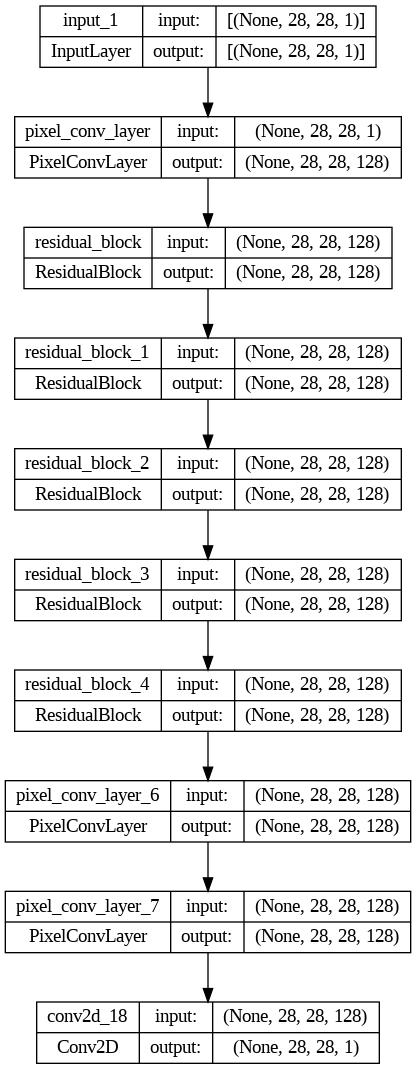

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(pixel_cnn, show_shapes=True, show_layer_names=True)

In [11]:
pixel_cnn.fit(
    x=X_PixelCNN, y=X_PixelCNN, batch_size=128, epochs=50, validation_split=0.1, verbose=1
)

Epoch 1/50
111/111 [==============================] - 28s 112ms/step - loss: 0.1578 - val_loss: 0.1260
Epoch 2/50
111/111 [==============================] - 12s 107ms/step - loss: 0.0822 - val_loss: 0.1187
Epoch 3/50
111/111 [==============================] - 12s 107ms/step - loss: 0.0789 - val_loss: 0.1160
Epoch 4/50
111/111 [==============================] - 12s 107ms/step - loss: 0.0775 - val_loss: 0.1146
Epoch 5/50
111/111 [==============================] - 12s 108ms/step - loss: 0.0767 - val_loss: 0.1143
Epoch 6/50
111/111 [==============================] - 12s 111ms/step - loss: 0.0762 - val_loss: 0.1135
Epoch 7/50
111/111 [==============================] - 12s 110ms/step - loss: 0.0758 - val_loss: 0.1158
Epoch 8/50
111/111 [==============================] - 12s 111ms/step - loss: 0.0757 - val_loss: 0.1129
Epoch 9/50
111/111 [==============================] - 12s 111ms/step - loss: 0.0752 - val_loss: 0.1136
Epoch 10/50
111/111 [==============================] - 12s 111ms/step - l

In [12]:
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
          
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    x = np.stack((x, x, x), 2)
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

  0%|          | 0/28 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 1/28 [00:01<00:53,  1.98s/it]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 2/28 [00:03<00:51,  1.99s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 3/28 [00:06<00:53,  2.13s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 4/28 [00:07<00:46,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 5/28 [00:09<00:41,  1.80s/it]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 6/28 [00:11<00:38,  1.75s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 7/28 [00:12<00:35,  1.70s/it]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 8/28 [00:14<00:33,  1.68s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 9/28 [00:15<00:31,  1.66s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 10/28 [00:18<00:32,  1.80s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 11/28 [00:20<00:32,  1.91s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 12/28 [00:21<00:29,  1.83s/it]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 13/28 [00:23<00:26,  1.77s/it]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 14/28 [00:25<00:23,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 15/28 [00:26<00:22,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 16/28 [00:28<00:21,  1.80s/it]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 17/28 [00:30<00:20,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 18/28 [00:33<00:19,  2.00s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 19/28 [00:34<00:16,  1.87s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 20/28 [00:36<00:14,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 21/28 [00:37<00:12,  1.74s/it]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 22/28 [00:39<00:10,  1.69s/it]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 23/28 [00:41<00:08,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 24/28 [00:42<00:06,  1.67s/it]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 25/28 [00:45<00:05,  1.83s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 26/28 [00:47<00:03,  1.89s/it]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 27/28 [00:48<00:01,  1.82s/it]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


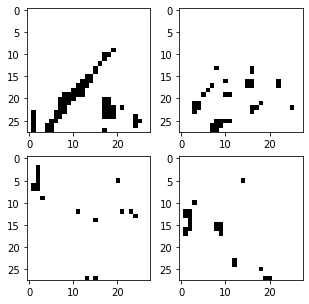

In [13]:
fig,ax = plt.subplots(2,2,figsize=(5,5))
for x in range(2):
    for y in range(2):
        ax[x,y].imshow(deprocess_image(np.squeeze(pixels[2*x+y], -1)))

## GANs

In [34]:
X_gans = X
X_gans = X_gans / 255.0 # Normalize the images to [0, 1]
BUFFER_SIZE = X_gans.shape[0] # 15703
BATCH_SIZE = 256

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_gans).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator

In [36]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [37]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

### Discriminator

In [38]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [39]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

## Loss and Optimizers


In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [41]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [42]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [44]:
checkpoint_dir = '/content/drive/MyDrive/gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [45]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)

In [47]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    loss0 = 0.
    loss1 = 0.

    for image_batch in dataset:
      losses = train_step(image_batch)
      loss0 += losses[0]
      loss1 += losses[1]

    print(loss0.numpy() / (15703//256), loss1.numpy().mean() / (15703//256))
    
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [48]:
images_dir = '/content/drive/MyDrive/'

In [49]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(os.path.join(images_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

## Train the model
The `train()` trains the generator and discriminator simultaneously.

As training progresses, the generated words will look increasingly real.

0.6208784384805648 1.0855557801293545


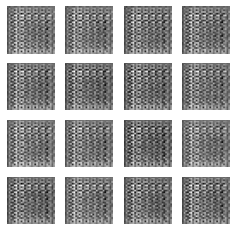

Time for epoch 1 is 8.196007490158081 sec
0.7830094509437436 1.02018925401031


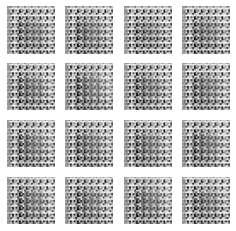

Time for epoch 2 is 3.730715036392212 sec
0.7923723439701268 1.311268915895556


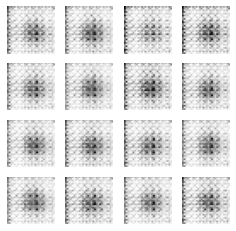

Time for epoch 3 is 4.1150500774383545 sec
0.6953810394787397 1.520872272428919


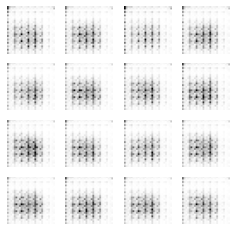

Time for epoch 4 is 3.7465322017669678 sec
0.6962109550100858 1.5002175002801614


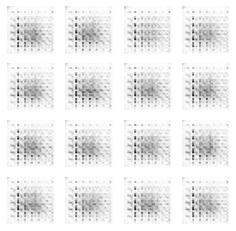

Time for epoch 5 is 3.566521167755127 sec
0.7302844563468558 1.4463254584640752


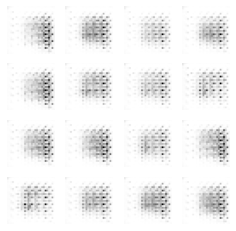

Time for epoch 6 is 3.5384304523468018 sec
0.6996662577644723 1.4443042942735016


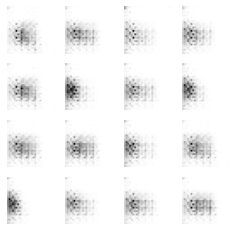

Time for epoch 7 is 3.5332834720611572 sec
0.7130204497790728 1.4375298922179176


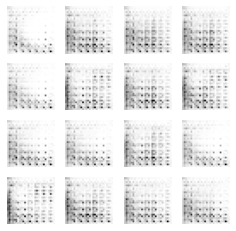

Time for epoch 8 is 3.843102216720581 sec
0.7142150753834209 1.4414577796810963


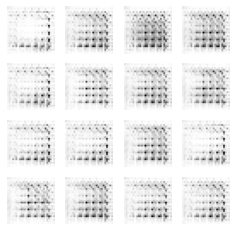

Time for epoch 9 is 5.612490177154541 sec
0.7455674468493853 1.4145237656890368


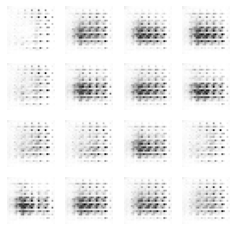

Time for epoch 10 is 3.6264989376068115 sec
0.7156283894523245 1.4142159633949154


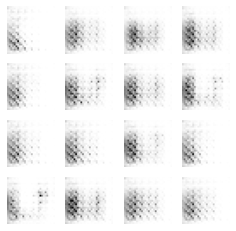

Time for epoch 11 is 3.772761106491089 sec
0.7329756939997438 1.3991432815301614


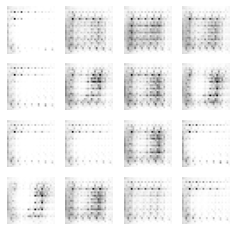

Time for epoch 12 is 3.7386820316314697 sec
0.7126456714067303 1.4140417380411117


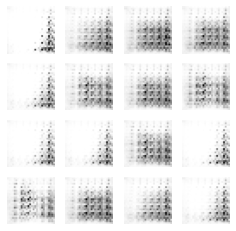

Time for epoch 13 is 3.6028153896331787 sec
0.7091614770107582 1.4017592883500896


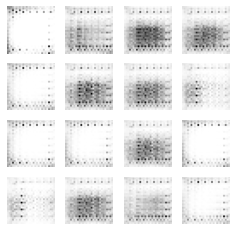

Time for epoch 14 is 3.615943431854248 sec
0.6958319241883325 1.4318933955958633


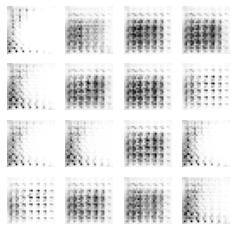

Time for epoch 15 is 4.152563095092773 sec
0.7035558106469326 1.407878312908235


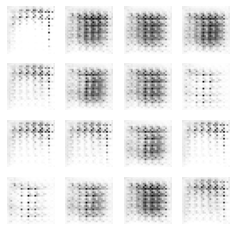

Time for epoch 16 is 3.614846706390381 sec
0.731544307020844 1.3995909143666752


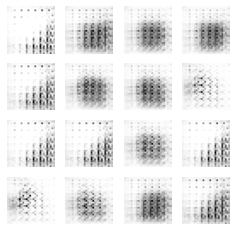

Time for epoch 17 is 3.670888900756836 sec
0.7148450632564357 1.4109443289334658


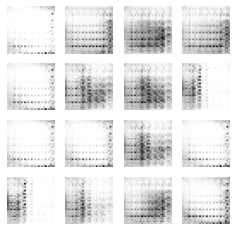

Time for epoch 18 is 3.899480104446411 sec
0.7132929192214715 1.3921257394259092


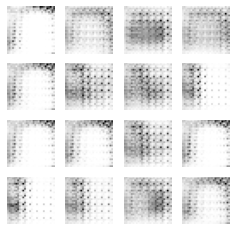

Time for epoch 19 is 4.185548543930054 sec
0.7734242423636014 1.3439906386078382


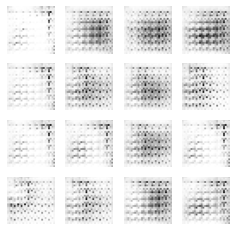

Time for epoch 20 is 3.878079414367676 sec
0.7943554862600858 1.3304203221055328


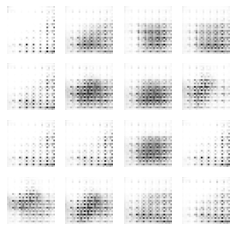

Time for epoch 21 is 3.689188003540039 sec
0.815079110567687 1.3084065171538806


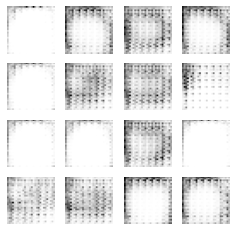

Time for epoch 22 is 4.353968620300293 sec
0.885910909683978 1.2395292188300462


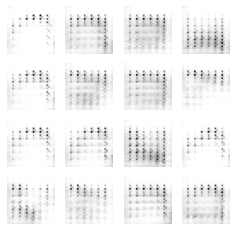

Time for epoch 23 is 3.8826191425323486 sec
0.7609030301453638 1.3590646962650488


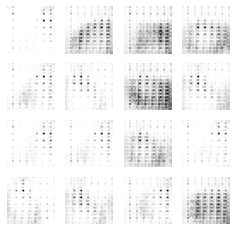

Time for epoch 24 is 3.640211582183838 sec
0.7670866544129419 1.388838345887231


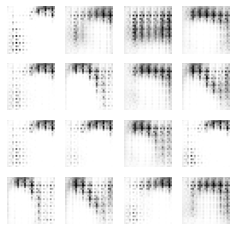

Time for epoch 25 is 3.8276233673095703 sec
0.9397324108686603 1.1714234899301998


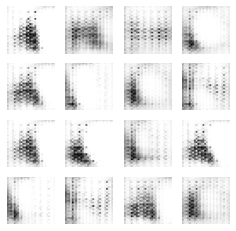

Time for epoch 26 is 3.8590729236602783 sec
0.8213621671082544 1.311567337786565


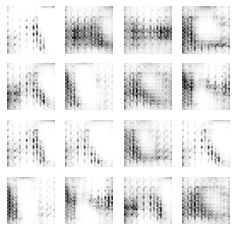

Time for epoch 27 is 3.642961025238037 sec
0.8746472343069608 1.2673133474881533


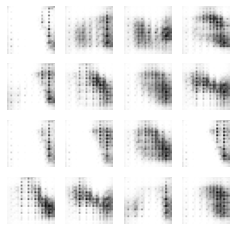

Time for epoch 28 is 3.5974998474121094 sec
0.7306412243452228 1.4370154709112448


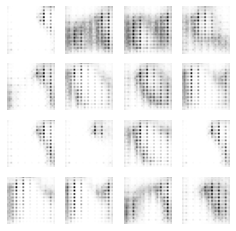

Time for epoch 29 is 3.840641975402832 sec
0.847788013395716 1.2819013751921107


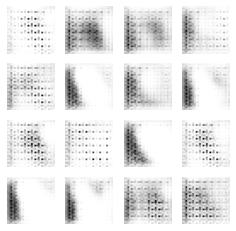

Time for epoch 30 is 4.089380264282227 sec
1.0010504175405033 1.1286593577900872


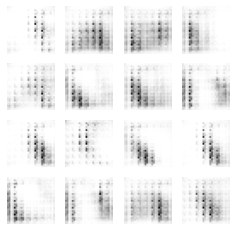

Time for epoch 31 is 3.605926036834717 sec
0.7491593908091061 1.4422659952132428


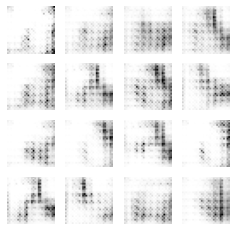

Time for epoch 32 is 3.82759165763855 sec
0.893148516045242 1.2450801661757172


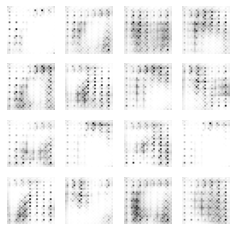

Time for epoch 33 is 3.844165802001953 sec
0.9793826869276704 1.1574586962090163


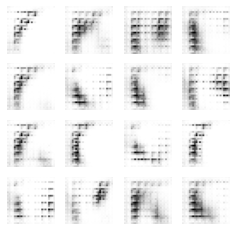

Time for epoch 34 is 3.6336536407470703 sec
1.1308403640496927 0.9511195948866548


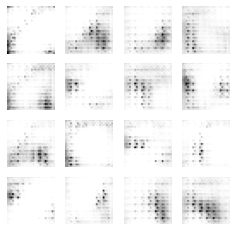

Time for epoch 35 is 3.618941307067871 sec
0.986473271104156 1.2728829305680072


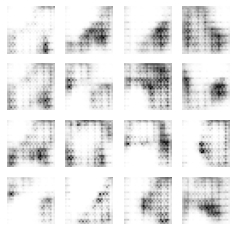

Time for epoch 36 is 3.8690061569213867 sec
0.9862547702476626 1.1913664770908043


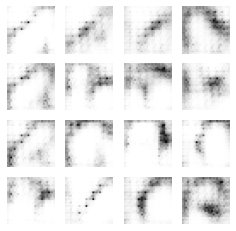

Time for epoch 37 is 3.8931591510772705 sec
0.9374850538910412 1.2273835979524206


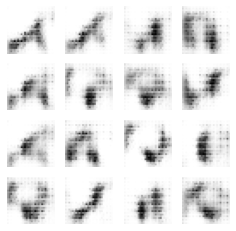

Time for epoch 38 is 3.626835346221924 sec
0.8437369299716637 1.3012557733254355


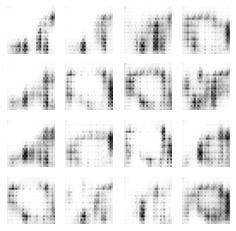

Time for epoch 39 is 3.8640122413635254 sec
1.0297069236880443 1.1458902828028945


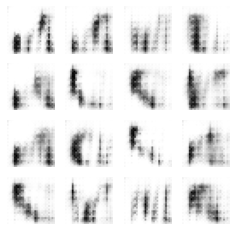

Time for epoch 40 is 3.737942934036255 sec
0.8526868351170274 1.3193619524846312


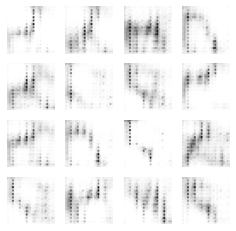

Time for epoch 41 is 3.6349740028381348 sec
0.8839148849737449 1.2792811159227715


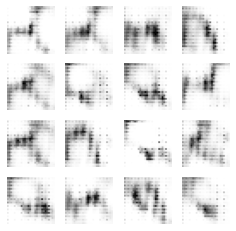

Time for epoch 42 is 3.6403119564056396 sec
0.7980097786324923 1.3480987548828125


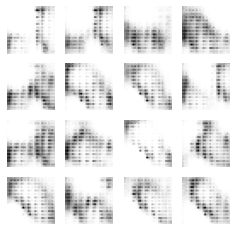

Time for epoch 43 is 3.893827438354492 sec
0.8783024647196785 1.3495698522348873


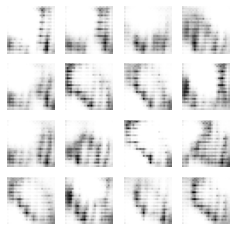

Time for epoch 44 is 3.8292460441589355 sec
0.956274501612929 1.2320225199715036


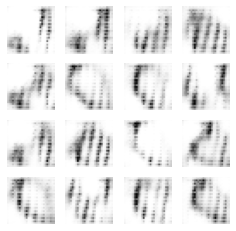

Time for epoch 45 is 3.8801426887512207 sec
0.8855368817438845 1.2543681410492444


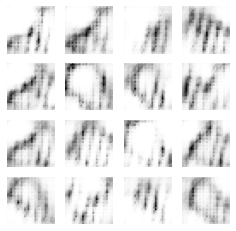

Time for epoch 46 is 3.829930305480957 sec
0.6962010117827869 1.5203468447825947


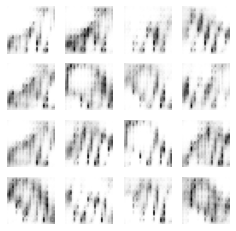

Time for epoch 47 is 3.623661518096924 sec
0.9560071601242316 1.2113723754882812


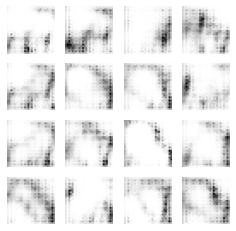

Time for epoch 48 is 3.6961517333984375 sec
0.9364837896628458 1.2882235167456455


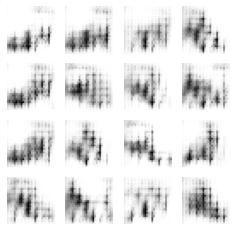

Time for epoch 49 is 3.6231441497802734 sec
0.7584980823954598 1.453845289886975


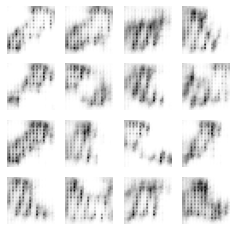

Time for epoch 50 is 3.825244188308716 sec


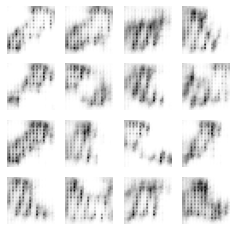

In [50]:
if tf.train.latest_checkpoint(checkpoint_dir) is None:
  train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [51]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [52]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(os.path.join(images_dir, 'image_at_epoch_{:04d}.png'.format(epoch_no)))

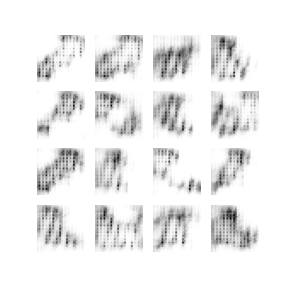

In [53]:
display_image(EPOCHS)